# Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn

#Building the Quantizer

In [4]:
def w8_a16_forward(weight, input, scales, bias=None):

    casted_weights = weight.to(input.dtype)
    output = F.linear(input, casted_weights) * scales

    if bias is not None:
        output = output + bias

    return output

In [5]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features,
                 bias=True, dtype=torch.float32):
        super().__init__()


        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )

        self.register_buffer("scales",
                             torch.randn((out_features), dtype=dtype))

        if bias:
            self.register_buffer("bias",
                                 torch.randn((1, out_features),
                                             dtype=dtype))

        else:
            self.bias = None

    def quantize(self, weights):
        w_fp32 = weights.clone().to(torch.float32)

        scales = w_fp32.abs().max(dim=-1).values / 127
        scales = scales.to(weights.dtype)

        int8_weights = torch.round(weights
                        /scales.unsqueeze(1)).to(torch.int8)

        self.int8_weights = int8_weights
        self.scales = scales

    def forward(self, input):
        return w8_a16_forward(self.int8_weights,
                              input, self.scales, self.bias)

In [6]:
def Quantizer(module,target_class, module_name_to_exclude):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and not \
        any([x == name for x in module_name_to_exclude]):
            old_bias = child.bias
            old_weight = child.weight

            new_module = target_class(child.in_features,
                                      child.out_features,
                                      old_bias is not None,
                                      child.weight.dtype)
            setattr(module, name, new_module)

            getattr(module, name).quantize(old_weight)

            if old_bias is not None:
              getattr(module, name).bias = old_bias
        else:
            # Recursively call the function for nested modules
            Quantizer(child,
                     target_class, module_name_to_exclude)

# Testing on a dummy model

In [7]:
class DummyModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = torch.nn.Embedding(1, 1)
    # Try with bias
    self.linear_1 = nn.Linear(1, 1)
    # Try without bias
    self.linear_2 = nn.Linear(1, 1, bias=False)
    # Lm prediction head
    self.lm_head = nn.Linear(1, 1, bias=False)

# Initial model skeleton (architecture)

In [8]:
model_3 : object = DummyModel()
print(model_3)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): Linear(in_features=1, out_features=1, bias=True)
  (linear_2): Linear(in_features=1, out_features=1, bias=False)
  (lm_head): Linear(in_features=1, out_features=1, bias=False)
)


## After quantization

In [9]:
Quantizer(model_3, W8A16LinearLayer, ["lm_head"])
print(model_3)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): Linear(in_features=1, out_features=1, bias=False)
)


# Testing on open-source models

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_id = "Salesforce/codegen-350M-mono"

model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                    torch_dtype=torch.bfloat16,
                                             low_cpu_mem_usage=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/797M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/797M [00:00<?, ?B/s]

Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

tokenizer_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [11]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

print(pipe("""print(x+y)
print(x/y)""", max_new_tokens=20, do_sample=False))

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': '"print(x+y)\nprint(x/y)\nprint(x+y)\nprint(x*y)\nprint(x-y'}]


In [13]:
Quantizer(model,W8A16LinearLayer, ["lm_head"])

## after Quantization

In [14]:
pipe.model

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): W8A16LinearLayer()
          (out_proj): W8A16LinearLayer()
        )
        (mlp): CodeGenMLP(
          (fc_in): W8A16LinearLayer()
          (fc_out): W8A16LinearLayer()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)

In [15]:
print(pipe("""print(x+y)
print(x/y)""", max_new_tokens=20,
           do_sample=False)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


print(x+y)
print(x/y)
print(x*y)
print(x-y)
print(x//y


# Testing on an object-detection model

In [16]:
import matplotlib.pyplot as plt
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(model, pil_img, results):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    scores, labels, boxes = results["scores"], results["labels"], results["boxes"]
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [17]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")

preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [18]:
previous_memory_footprint = model.get_memory_footprint()

In [19]:
print("Footprint of the model in MBs: ",
      previous_memory_footprint/1e+6)

Footprint of the model in MBs:  166.524032


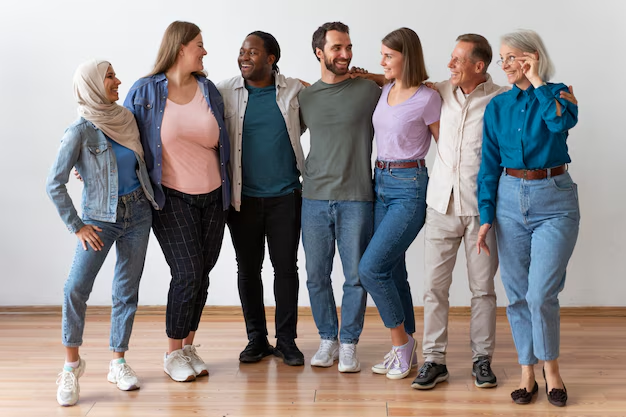

In [20]:
img_path = "/content/people-posing-together-registration-day_23-2149096794.avif"
image = Image.open(img_path).convert("RGB")
image

In [21]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

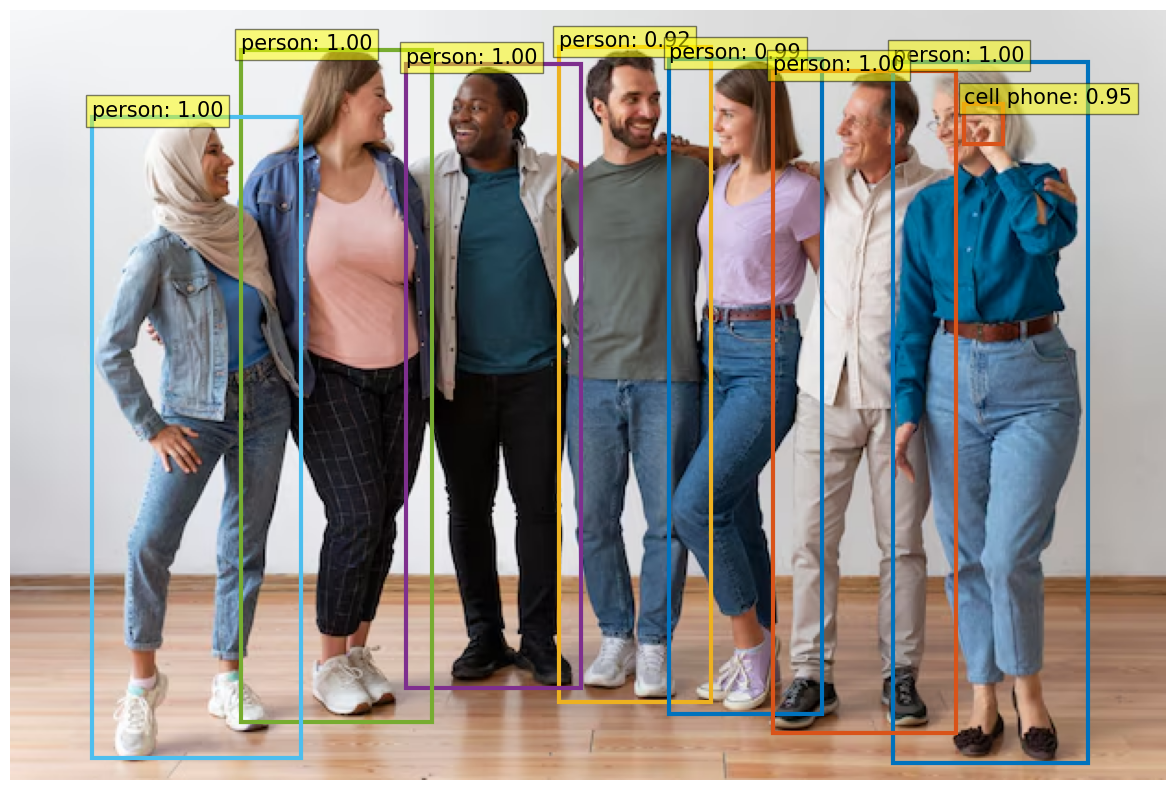

In [22]:
plot_results(model,image,results)

In [23]:
Quantizer(model, W8A16LinearLayer, ["0", "1", "2", "class_labels_classifier"])

## After Quantization

In [24]:
### Model after quantization
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [25]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

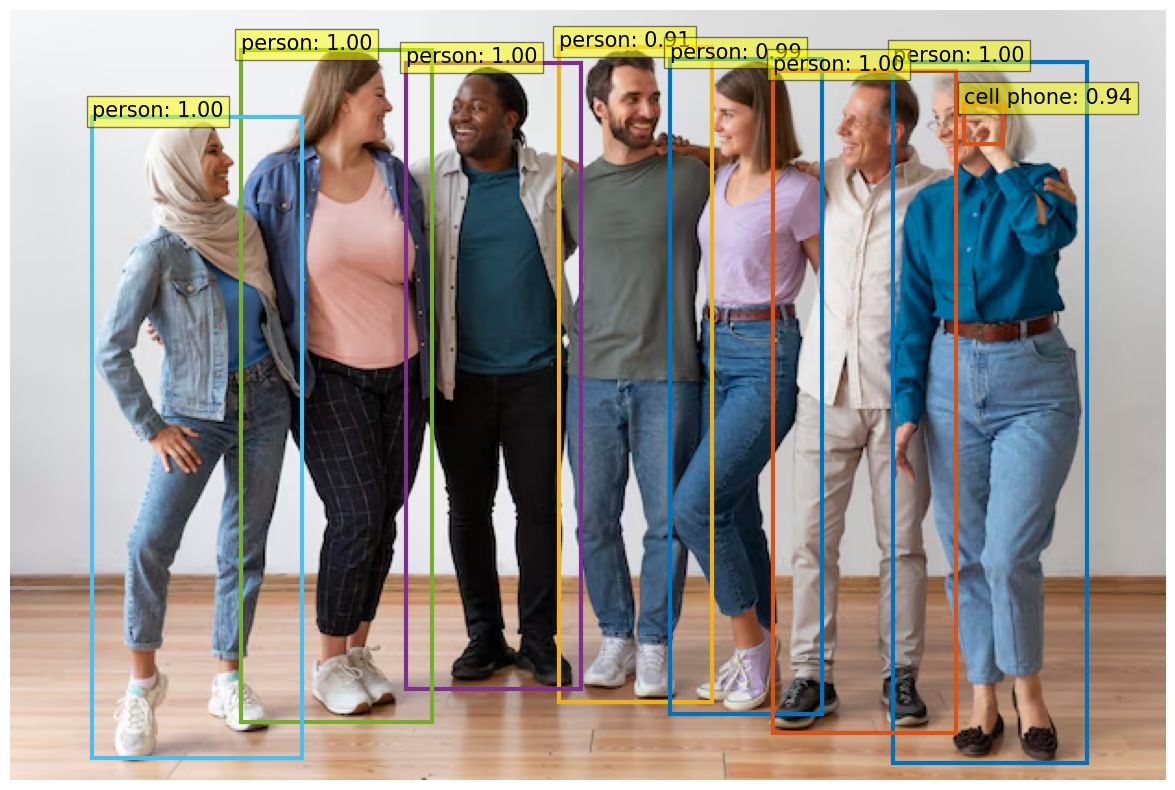

In [26]:
plot_results(model,image,results)

In [27]:
new_footprint = model.get_memory_footprint()

In [28]:
print("Footprint of the model in MBs: ",
      new_footprint/1e+6)

Footprint of the model in MBs:  114.80384


In [29]:
### Memory saved
print("Memory saved in MBs: ",
      (previous_memory_footprint - new_footprint)/1e+6)

Memory saved in MBs:  51.720192
